# Localized analysis

In [2]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts

print_figs = True

---

# Band-pass filtering


## utils

In [3]:
def bpass_filter(omega,
                 domega, 
                 numtaps=10*24, 
                 dt=1./24.,
                 ftype='firwin2',
                ):
    ''' Wrapper around scipy.signal.firwing
    dt: float
        days
    omega: float
        cpd
    '''
    #
    if ftype=='firwin':
        h = signal.firwin(numtaps, 
                          cutoff=[omega-domega, omega+domega], 
                          pass_zero=False, 
                          nyq=1./2/dt, 
                          scale=True,
                         )
    elif ftype=='firwin2':
        h = signal.firwin2(numtaps, 
                           [0, omega-domega, omega-domega*0.5, omega+domega*0.5, omega+domega, 1./2/dt], 
                           [0, 0, 1, 1, 0, 0],
                           nyq=1./2/dt,
                          )
    #
    t = np.arange(numtaps)*dt
    return h, t
        
def filter_response(h, dt=1./24.):
    ''' Returns the frequency response
    '''
    w, h_hat = signal.freqz(h, worN=8000)
    return h_hat, (w/np.pi)/2/dt

def convolve(x, h=None, hilbert=False):
    x_f = im.convolve1d(x, h, axis=1, mode='constant')
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    output_sizes={'time': len(v.time)})

### firwin vs firwin2

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [4]:
sigma = 2.
domega = .3

F = {}
for f in ['firwin', 'firwin2']:
    
    h, t  = bpass_filter(sigma, domega, ftype=f)
    h_hat, w = filter_response(h)
    
    F[f] = dict(h=h, t=t, h_hat=h_hat, w=w, domega=domega, sigma=sigma)    

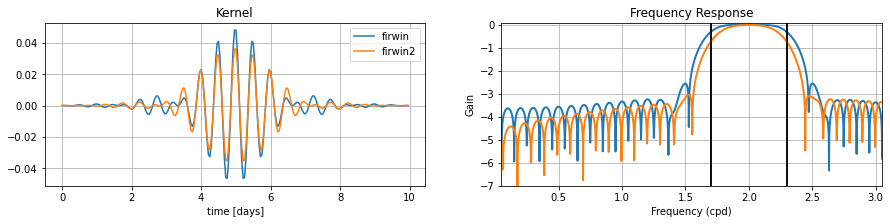

In [5]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
for ftype, f  in F.items():
    ax.plot(f['t'], f['h'], label=ftype)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
for ftype, f  in F.items():
    ax.plot(f['w'], np.log10(abs(f['h_hat'])), linewidth=2, label=ftype)
    ax.axvline(f['sigma']-f['domega'], color='k')
    ax.axvline(f['sigma']+f['domega'], color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

### sensitivity to kernel length

with firwin

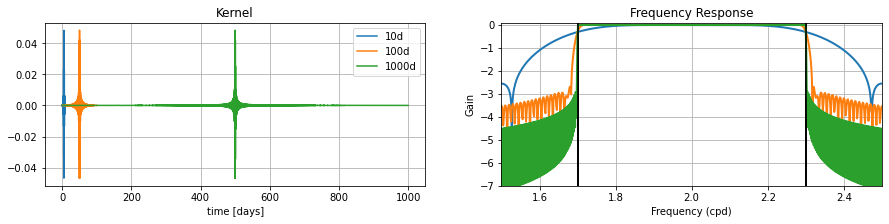

In [30]:
sigma = 2.
domega = .3

N = [10*24, 100*24, 1000*24]

FN = {}
for n in N:
    
    h, t  = bpass_filter(sigma, domega, numtaps=n, ftype='firwin')
    h_hat, w = filter_response(h)
    
    FN[n] = dict(h=h, t=t, h_hat=h_hat, w=w, domega=domega, sigma=sigma)    
    
#
    
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
for n, f  in FN.items():
    ax.plot(f['t'], f['h'], label="{:d}d".format(int(n/24)))
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
for n, f  in FN.items():
    ax.plot(f['w'], np.log10(abs(f['h_hat'])), linewidth=2, label="{:d}d".format(int(n/24)))
    ax.axvline(f['sigma']-f['domega'], color='k')
    ax.axvline(f['sigma']+f['domega'], color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
#ax.set_xlim(0.05, 3.05)
ax.set_xlim(1.5, 2.5)
ax.grid(True)

## low-frequency signal

- theoretical output amplitude for an ideal band-pass filter
- illustrative example

How much energy is left after band-pass filtering

In [31]:
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()

- filter bandwidth = $2\delta_\omega$
- U = signal amplitude (standard deviation)
- $T$ = signal decorrelation time scale (exponential autocorrelation)

In [32]:
delta = Symbol('delta_omega', positive=True)
T, sigma, U = u_low.p['T'], u_low.p['sigma'], u_low.p['U']
omega, tau = u_low.omega, u_low.tau

In [33]:
u_low.spectrum

2*T*U**2/(T**2*omega**2 + 1)

In [34]:
I_low = u_low.spectrum.integrate((omega, sigma-delta, sigma+delta)) *2  /2/pi
I_low = I_low.simplify()
E_low = lambdify([U, T, sigma, delta], I_low)
I_low

2*U**2*(atan(T*(delta_omega - sigma)) + atan(T*(delta_omega + sigma)))/pi

In [35]:
I_low.args

(2, 1/pi, U**2, atan(T*(delta_omega - sigma)) + atan(T*(delta_omega + sigma)))

In [36]:
# manually simplify the sum of arc tangents
# https://fr.wikipedia.org/wiki/Identité_trigonométrique
_x = I_low.args[3].args[0].args[0]
_y = -I_low.args[3].args[1].args[0]
_xy = (_x-_y)/(1+_x*_y)
_xy = _xy.func(*(factor(term) for term in _xy.args))

# hypothèse T x sigma > 1
I_low = I_low.args[0] * I_low.args[1] * atan(_xy)
I_low

-2*atan(2*T*delta_omega/(T**2*delta_omega**2 - T**2*sigma**2 - 1))/pi

Limits when $\sigma T\gg 1$ (while $\delta_\omega < \sigma$) : 

Here $T$ is the low-frequency signal decorrelation time scale, 
$\sigma$ the high-frequency signal frequency and $\delta_\omega$ a filtering half bandwidth.

In [37]:
U**2 * 4*delta/T/sigma**2 /pi

4*U**2*delta_omega/(pi*T*sigma**2)

### Illustration

In [38]:
da = u_low.generate_tseries(time=(1000,1/24), tau=[2,5,10,20,40]).persist()

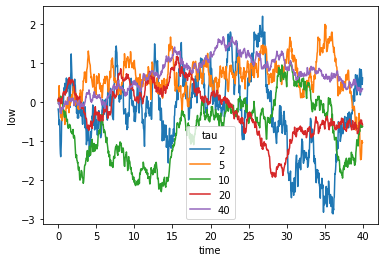

In [39]:
_ = da.where(da.time<40).plot.line(x='time')

/Users/aponte/.miniconda3/envs/stats/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


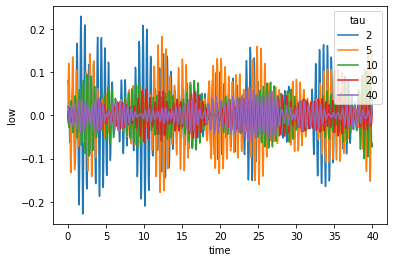

In [40]:
f = F['firwin']
da_filtered = filt(da, f['h'])
_ = da_filtered.where(da.time<40).plot.line(x='time')

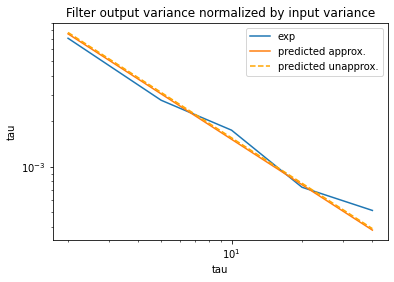

In [44]:
ax = plt.subplot(111)
(da_filtered.var('time')/da.var('time') ).plot(ax=ax, label='exp')

# sigma is converted only once to rad/d because of the ratio delta_omega/sigma
r = 4*f['domega']/(np.pi*da.tau*2*np.pi*f['sigma']**2)
r.plot(ax=ax, label='predicted approx.')
rbis = E_low(1., da.tau, 2*np.pi*f['sigma'], 2*np.pi*f['domega'])
rbis.plot(ax=ax, label='predicted unapprox.', color='orange', ls='--')

#ax.axhline(1e-3, color='k')
ax.legend()
ax.set_title('Filter output variance normalized by input variance')

ax.set_xscale("log")
ax.set_yscale("log")

**Conclusion**: the variance that leaks out varies as $U^2 \times 4\delta_\omega/T\sigma^2$.

It varies linearly with filter bandwidth, inversely with the slow-signal decorrelation time scale and inversely with the square of the high-frequency signal frequency.

### high-frequency signal

- theoretical output amplitude for an ideal band-pass filter
- illustrative example

- filter bandwidth = $2\delta_\omega$
- U = signal amplitude (standard deviation)
- $\sigma$: signal frequency and band-pass filter central frequency
- $T$ = signal decorrelation time scale (exponential autocorrelation of the enveloppe)

In [47]:
I_high = u_high.spectrum.integrate((omega, sigma-delta, sigma+delta)) *2  /2/pi
I_high = I_high.simplify()
#E_high = lambdify([U, T, sigma, delta], I_high)
I_high

U**2*(atan(T*(delta_omega - sigma)/2) + atan(T*(delta_omega + sigma)/2) + atan(T*(delta_omega - sigma)*(-T**2*sigma**2 + T**2*(delta_omega - sigma)**2 + 3)/(2*(T**2*sigma**2 + 1))) + atan(T*(delta_omega + sigma)*(-T**2*sigma**2 + T**2*(delta_omega + sigma)**2 + 3)/(2*(T**2*sigma**2 + 1))))/pi

In [48]:
# normalize parameters
s = Symbol('s', positive=True)
d = Symbol('d', positive=True)
I_high_norm = I_high.subs({sigma:s/T, delta:d/T}).simplify()
E_high_norm = lambdify([U, s, d], I_high_norm)
I_high_norm

U**2*(atan((d - s)*(-s**2 + (d - s)**2 + 3)/(2*(s**2 + 1))) + atan((d + s)*(-s**2 + (d + s)**2 + 3)/(2*(s**2 + 1))) + atan(d/2 - s/2) + atan(d/2 + s/2))/pi

In [49]:
_delta = np.linspace(0, 2., 100)
_s = [1, 10, 20]
ds = xr.Dataset(None, coords={'delta': (['delta'], _delta),
                              'sigma': (['sigma'], _s)},)
ds['E'] = E_high_norm(1., 2*np.pi*ds.sigma, 2*np.pi*ds.delta)

Text(0.5, 1.0, 'Fraction of output variance recovered')

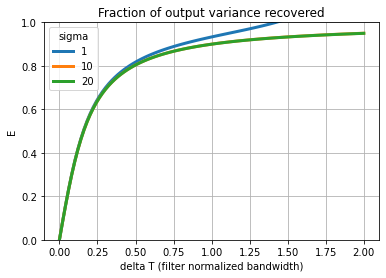

In [50]:
ax = plt.subplot(111)
ds.E.plot.line(x='delta', ax=ax, lw=3)
ax.grid()
ax.set_ylim(0,1)
ax.set_xlabel('delta T (filter normalized bandwidth)')
ax.set_title('Fraction of output variance recovered')

**Conclusion:** 90% of the total variance is recovered if the filter bandwidth is $1/T$

A filter should at least be of width $1/T$, but $T$ is partially unknown in practice.
So we'd like to the filter to be wider.
This may however lead to projection of the low frequency signal.

The variance of a sum signal is (assuming $\delta_\omega T_{high} > 1$):

$
\begin{align}
U_{sum}^2 = 
U_{low}^2 \times 4\delta_\omega/T_{low}\sigma^2
+
U_{high}^2
\end{align}
$

We'd like the cross-projection to stay below a $\epsilon$ threshold (for example 10\%):

$
\begin{align}
\delta_\omega
&< \sigma \times \epsilon \frac{T_{low}\sigma}{4} \frac{U_{high}^2}{U_{low}^2}
\end{align}
$

Recollecting the lower bound assumed on $\delta_\omega$, such filtering is only possible if:

$
\begin{align}
\epsilon 
\times (T_{high}\sigma)
\times (T_{low}\sigma) 
>
4 \frac{U_{low}^2}{U_{high}^2}
\end{align}
$

The later ratio can be used to diagnose a critical amplitude ratios, or time scale values

**An illustration would be welcome here:**
fix temporal scales and vary amplitude ratios.

For small ratios, 

What should we do in defavorable situations?

What's going on in the real ocean?

---

## Hilbert transform

In [20]:

#------------------------------ spectrum ---------------------------------------
          
#[psi,lambda] = sleptap(size(uv2,1),2,1);
#% calculate all spectra, linearly detrend
#tic;[f,spp2,snn2] = mspec(1/24,detrend(uv2,1),psi);toc         
#[PSI,LAMBDA]=SLEPTAP(N,P,K) calculates the K lowest-order Slepian
#    tapers PSI of length N and time-bandwidth product P, together with
#    their eigenvalues LAMBDA. PSI is N x K and LAMBDA is K x 1.

# scipy.signal.windows.dpss(M, NW, Kmax=None, sym=True, norm=None, return_ratios=False)          
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.dpss.html#scipy.signal.windows.dpss
            
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 60*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')